In [1]:
import pygad
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd

In [2]:
# Генерация случайных данных для 100 транспортных средств
vehicle_classes = np.random.choice(['A', 'B', 'C', 'D', 'E', 'F'], size=20)
imo = np.random.randint(low=9000000, high=9999999, size=20)
speeds = np.random.randint(low=0, high=20, size=20)
start_times = np.random.randint(low=0, high=30, size=20)
end_times = start_times + np.random.randint(low=1, high=30, size=20)
start_points = np.random.randint(low=0, high=3, size=20)
end_points = np.random.randint(low=0, high=4, size=20)

# Создание датасета с сгенерированными данными
vehicle_data = pd.DataFrame({
    'class': vehicle_classes,
    'imo': imo,
    'speed': speeds,
    'start_time': start_times,
    'end_time': end_times,
    'start_point': start_points,
    'end_point': end_points
})

In [3]:
vehicle_speeds = {}
recommended_start_times = {}
recommended_end_times = {}
start_points = {}
end_points = {}
for index, row in vehicle_data.iterrows():
    vehicle_class = row['class']
    imo_value = row['imo']
    speed = row['speed']
    start_time = row['start_time']
    end_time = row['end_time']
    start_point = row['start_point']
    end_point = row['end_point']
    vehicle_speeds[vehicle_class] = speed
    recommended_start_times[vehicle_class] = start_time
    recommended_end_times[vehicle_class] = end_time
    start_points[vehicle_class] = start_point
    end_points[vehicle_class] = end_point

In [4]:
num_routes = len(start_points)
eta_values = 2
print(num_routes)
print(start_points)

6
{'C': 2, 'A': 1, 'F': 1, 'E': 2, 'D': 1, 'B': 2}


In [5]:
def fitness_function(solution, solution_idx):
    # Разделение генетической популяции на маршруты
    routes = np.split(solution, num_routes, axis=0)
    print(routes)
    # Вычисление значения целевой функции для каждого маршрута
    fitness_values = []
    for route in routes:
        # Добавление начальной точки в маршрут
        print(solution_idx)
        route = np.insert(route, 0, start_point)
        
        # Вычисление значения первого критерия - суммарного отклонения от ETA
        eta_deviations = np.abs(route - eta_values)
        eta_deviation_sum = np.sum(eta_deviations)

        # Вычисление значения второго критерия - суммарного пройденного расстояния
        distance_sum = np.sum(route)

        # Вычисление значения третьего критерия - потери скорости движения
        speed_loss = 0
        for i in range(1, len(route)):
            # Определение класса транспортного средства на основе данных из датасета
            vehicle_class = vehicle_data.loc[i, 'class']
            # Проверка возможности пройти по маршруту выше классом сплоченности
            if route[i] > route[i-1]:
                # Проверяем наличие судна соответствующего класса в караване
                caravan = route[:i]
                if vehicle_class in caravan:
                    continue  # Можем двигаться выше классом сплоченности

            # Вычисление потери скорости на основе класса транспортного средства
            speed = vehicle_speeds[vehicle_class]
            distance = route[i] - route[i-1]
            speed_loss += (1 - (speed / 100)) * distance

        # Учет рекомендуемого времени начала и окончания движения
        start_time = recommended_start_times[vehicle_class]
        end_time = recommended_end_times[vehicle_class]
        time_loss = 0

        # Проверка, находится ли маршрут вне рекомендуемого временного интервала
        if route[1] < start_time or route[-1] > end_time:
            time_loss = 100  # Высокая штрафная функция для маршрутов, не соответствующих рекомендуемым временам

        # Вычисление значения целевой функции
        fitness_value = eta_deviation_sum + distance_sum + speed_loss + time_loss

        # Добавление значения целевой функции в список
        fitness_values.append(fitness_value)

    # Выбор одного значения из списка, например, среднего значения
    fitness_value = np.mean(fitness_values)

    # Возвращение значения целевой функции
    return fitness_value

In [6]:
# Создание экземпляра генетического алгоритма
ga_instance = pygad.GA(
    num_generations=100,  # Количество поколений
    num_parents_mating=10,  # Количество родительских пар для спаривания
    fitness_func=fitness_function,  # Функция приспособленности
    sol_per_pop=50,
    num_genes=num_routes,
    mutation_type=None
)

In [7]:
# Запуск генетического алгоритма
ga_instance.run()

[array([0.20542922]), array([-0.86092856]), array([-0.66008554]), array([-3.73715389]), array([0.98812603]), array([0.11835656])]
0
0
0
0
0
0
[array([3.47401355]), array([-1.27447714]), array([-3.76129372]), array([3.24197552]), array([-2.16504392]), array([-1.75001087])]
1
1
1
1
1
1
[array([-0.23139338]), array([1.80651701]), array([-0.26063464]), array([-1.50577107]), array([1.64672514]), array([0.08856596])]
2
2
2
2
2
2
[array([2.58028787]), array([2.24695383]), array([1.92698878]), array([0.69301936]), array([1.88503848]), array([-2.66207547])]
3
3
3
3
3
3
[array([0.81204042]), array([-1.24282575]), array([-0.88762005]), array([0.43370449]), array([0.02590052]), array([-0.60679735])]
4
4
4
4
4
4
[array([-2.94074298]), array([-0.61087235]), array([1.989691]), array([-3.4702752]), array([-2.40628987]), array([0.10143701])]
5
5
5
5
5
5
[array([-0.82085153]), array([0.64736466]), array([-0.99172959]), array([-2.98640975]), array([-0.06810719]), array([3.1285631])]
6
6
6
6
6
6
[array([1

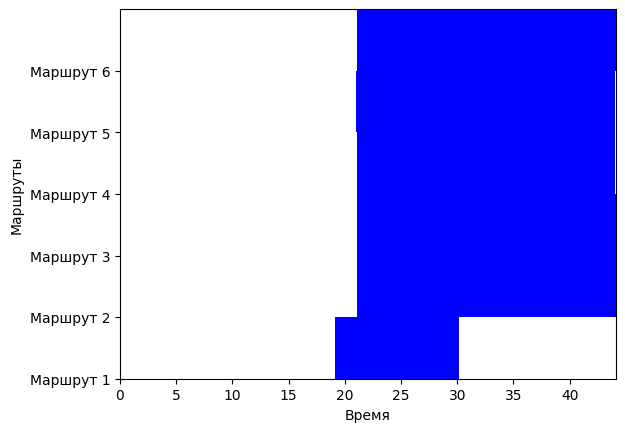

In [8]:
# Визуализация результатов
# Получение лучшего решения из генетического алгоритма
best_solution = ga_instance.best_solution()[0]

# Разделение генетического решения на маршруты
routes = np.split(best_solution, num_routes, axis=0)

# Создание списков для времени начала и окончания каждого маршрута
start_times = []
end_times = []

# Заполнение списков времени начала и окончания каждого маршрута
for route in routes:
    # Добавление начальной точки в маршрут
    route = np.insert(route, 0, start_point)

    # Вычисление времени начала и окончания каждого маршрута
    start_time = recommended_start_times[vehicle_class]
    end_time = recommended_end_times[vehicle_class]

    for i in range(1, len(route)):
        # Определение класса транспортного средства на основе данных из датасета
        vehicle_class = vehicle_data.loc[i, 'class']

        # Проверка возможности пройти по маршруту выше классом сплоченности
        if route[i] > route[i-1]:
            # Проверяем наличие судна соответствующего класса в караване
            caravan = route[:i]
            if vehicle_class in caravan:
                continue  # Можем двигаться выше классом сплоченности

        # Вычисление времени движения на основе класса транспортного средства и расстояния
        speed = vehicle_speeds[vehicle_class]
        distance = route[i] - route[i-1]
        time = distance / speed

        # Вычисление времени начала и окончания каждого маршрута
        start_time += time
        end_time += time

    # Добавление времени начала и окончания в соответствующие списки
    start_times.append(start_time)
    end_times.append(end_time)

# Создание диаграммы Ганта
fig, ax = plt.subplots()

# Отрисовка полос для каждого маршрута
for i in range(len(routes)):
    ax.broken_barh([(start_times[i], end_times[i] - start_times[i])], (i, 1), facecolors='blue')

# Настройка осей и меток
ax.set_ylim(0, len(routes))
ax.set_xlim(0, max(end_times))
ax.set_xlabel('Время')
ax.set_ylabel('Маршруты')
ax.set_yticks(range(len(routes)))
ax.set_yticklabels(['Маршрут {}'.format(i+1) for i in range(len(routes))])

# Отображение диаграммы Ганта
plt.show()

In [9]:
# Формирование данных для JSON
data = {
    "best_solutions": best_solution,
    "best_fitness": best_fitness
}

# Сериализация данных в JSON-строку
json_data = json.dumps(data)

# Отправка JSON-строки
# ...

NameError: name 'best_fitness' is not defined